# Non iterative

status: 0 in 133
nome pre-result: 3DVolumeSegmented_10194022_left_225.npy
paciente_result: 43151324
region_indice: left
indice_mask: 43151324
shape segmentação: (104, 100, 100)
shape ground truth: (104, 100, 100)

-----------------------------------------------------------------------------------------
TP, TN, FP, FN: [5191, 1034263, 239, 307]
Elapsed time: 0.019 seconds.


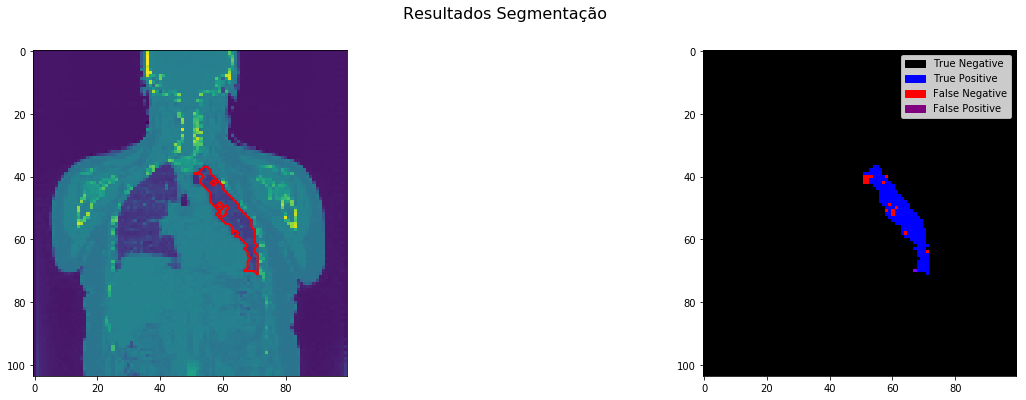

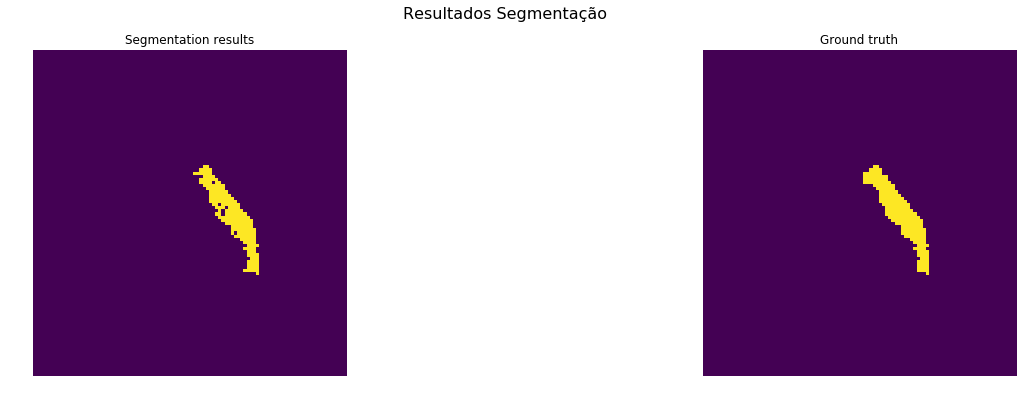

Metrics:
Dice: 0.9500366032210834
Jacquard Index: 0.9048283074777759
True Positive Rate: 0.9441615132775555
Volumetric Similarity: 0.9937774524158126

-----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------


In [49]:
from segmentation_functions import resample
from finding_biggest_lung import arrange_slices, normalization, creating_mask
from automaticSeeding import find_seed #confirmar que não é o primeiro metodo
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time
from segmentation_metrics import compare_volumes_lighter, plotResultsSegmentationImage_WithContours, Dice, Jac, TruePR, VoluM, MutualI
#from math import sqrt


slices_path = "G:/CTimages/"
indices_path ="G:/Plans/CT/Lungs/ok/Separate Lungs/"
seeds_path = "G:/CTimages/Seeds/"
separation_path = "G:/CTimages/Separator/"
centroid_path = "G:/CTimages/Centroids/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/third_method/"
indices_folder= os.listdir(indices_path)


segmentation_folder= os.listdir(segmentations_results_path)
metrics_methods = []
masks = []

results = os.listdir(segmentations_results_path)
a = 0
metrics = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []
for num,pre_result in enumerate(results[0:1]):#dir of results for each method

    print('status: '+str(num)+' in '+str(len(results)))
    print('nome pre-result: ' +str(pre_result))
    split_id = pre_result.split('_', pre_result.count(pre_result))[1]
    
    
    result_id = split_id.split('_', split_id.count(split_id))[0]
    print('paciente_result: '+str(result_id))
    indexes = os.listdir(indices_path)
    indice_id = indexes[a].split(" ")[0]
    
    
    region = indexes[a].split("_")[1]
    print('region_indice: '+str(region))

    print('indice_mask: '+str(indice_id))

    #Reading data--------------------------------------------------------------------------------------------------
    indexes_mask = spio.loadmat(indices_path+ indexes[a], squeeze_me=True)["indexes"] #USAR TRY AND CATCH 
    indexes_mask = spio.loadmat(indices_path+ str(indice_id)+" - ct_left_lung_coordinates", squeeze_me=True)["indexes"]
    slices = arrange_slices(slices_path, result_id)
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    volume_resampled,spacing = resample(normalized_array, slices, [5,5,5])

    # Ground Truth
    ground_truth = creating_mask(indexes_mask,normalized_array)
    ground_truth_resampled,spacing = resample(ground_truth, slices, [5,5,5])
    ground_truth_boolean = np.where(ground_truth_resampled>0.5, 1, 0)

    # Segmentation results
    result_segment= np.load(segmentations_results_path +'3DVolumeSegmented_'+indice_id+'_left_225.npy')
    result_segment_boolean= np.where(result_segment==True, 1, 0)

    print('shape segmentação: '+str(result_segment_boolean.shape))
    print('shape ground truth: '+str(ground_truth_boolean.shape))

    print('\n'+'-----------------------------------------------------------------------------------------')

    #Metrics--------------------------------------------------------------------------------------------------------
    #start_1=time.time()
    #TP_1, TN_1, FP_1, FN_1 = compare_volumes(mask_resampled_boolean,result_boolean)
    #stop_1=time.time()
    #print(TP_1, TN_1, FP_1, FN_1)
    #print("Elapsed time: %.3f seconds." % (stop_1 - start_1))
    start=time.time()
    TP, TN, FP, FN = compare_volumes_lighter(ground_truth_boolean,result_segment_boolean)
    stop=time.time()
    TP_list.append(TP)
    FP_list.append(FP)
    TN_list.append(TN)
    FN_list.append(FN)
    name = segmentations_results_path+"Metrics_Tp_Fp, Tn, Fn"
    np.save(name, [TP_list,FP_list,TN_list,FN_list])
    
    print('TP, TN, FP, FN: '+str([TP, TN, FP, FN]))
    print("Elapsed time: %.3f seconds." % (stop - start))
    half_rows = result_segment_boolean.shape[1]//2

    contours = measure.find_contours(result_segment_boolean[:,half_rows,:], 0.9)
    #def plot_results_segmentation_image(truth_image, prediction, normal_image):
    img = plotResultsSegmentationImage_WithContours(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,half_rows,:], contours)
    fig = plt.figure(figsize=(22,6))  
    fig.suptitle("Segmentation Results", fontsize=16)
    y = fig.add_subplot(1,2,1)
    y.axis('off')
    y.imshow(result_segment_boolean[:,half_rows,:])
    y.set_title("Segmentation Mask")
    x = fig.add_subplot(1,2,2)
    x.axis('off')
    x.imshow(ground_truth_boolean[:,half_rows,:])
    x.set_title("Ground truth")
    plt.show()

    identification = indice_id+'_'+region
    dice = Dice(TP,FP,FN)
    jac = Jac(TP,FP,FN)
    truePr = TruePR(TP,FN)
    vs = VoluM(TP,FP, FN)
    #mi = MutualI(TP,TN,FP,FN)
    avaliation =tuple([dice,jac,truePr,vs])
    result = tuple([identification,avaliation])
    metrics.append(result)

    print('Metrics:')
    print('Dice: '+str(dice))
    print('Jacquard Index: '+str(jac))
    print('True Positive Rate: '+str(truePr))
    print('Volumetric Similarity: '+str(vs))
    #print('Mutual Information: '+str(mi))
    print('\n'+'-----------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------')

    a=a+1
metrics_methods.append(metrics)
name = segmentations_results_path+"Metrics_Tp_Fp, Tn, Fn"
np.save(name, metrics)


In [ ]:
dice =[]
jac = []
tpr = []
vs = []

for i in metrics:
    #dice = i[1][0]
    dice.append(i[1][0])
    jac.append(i[1][1])
    tpr.append(i[1][2])
    vs.append(i[1][3])


# Iterative

In [ ]:
from segmentation_functions import resample
from finding_biggest_lung import arrange_slices, normalization, creating_mask
from automaticSeeding import find_seed #confirmar que não é o primeiro metodo
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time
from segmentation_metrics import compare_volumes_lighter, plot_results_segmentation_image, plotResultsSegmentationImage_WithContours, Dice, Jac, TruePR, VoluM, MutualI
from skimage import measure
import matplotlib.patches as mpatches
#from math import sqrt

def plotResultsSegmentationImage_WithContours2(truth_image_ori, prediction_segment, normal_image, contours):
    #Code adapted from KenobiShan and from kraskevich, 
    #available on https://codereview.stackexchange.com/questions/177898/calculate-true-positive-false-positive-
    #true-negative-and-false-negative-and-co
     
    prediction = prediction_segment.astype(np.uint8)
    truth_image = truth_image_ori.astype(np.uint8)

    output_image = np.empty(shape=(prediction.shape[0], prediction.shape[1], 4), dtype=np.uint8)

    true_positive_mask = np.logical_and(truth_image ==1 , prediction == 1)
    true_negative_mask = np.logical_and(truth_image ==0 , prediction == 0)
    false_positive_mask = np.logical_and(truth_image ==0 , prediction == 1)
    false_negative_mask = np.logical_and(truth_image ==1 , prediction == 0)
    
    background_mask = np.logical_and(truth_image ==0 , prediction == 0)
    
    # B-G-R-A
    red = [255, 0, 0, 255]
    green = [0, 255, 0, 255]
    blue = [0, 0, 255, 255]
    purple =  [128, 0, 255, 255]
    black = [0, 0, 0, 255]

    output_image[background_mask] = black  
    output_image[true_positive_mask] = blue 
    output_image[true_negative_mask] = black 
    output_image[false_positive_mask] = purple
    output_image[false_negative_mask] = red  
    

    
    fig_2 = plt.figure(figsize=(22,6))  
    fig_2.suptitle("Resultados Segmentação", fontsize=16)
    y = fig_2.add_subplot(1,2,1)
    y.imshow(normal_image, interpolation='nearest')
    for n, contour in enumerate(contours):
        y.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

    x = fig_2.add_subplot(1,2,2)
    black_patch = mpatches.Patch(color='black', label='True Negative')
    blue_patch = mpatches.Patch(color='blue', label='True Positive')
    red_patch = mpatches.Patch(color='red', label='False Negative')
    purple_patch = mpatches.Patch(color='purple', label='False Positive')
    plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x.imshow(output_image)
    return output_image


slices_path = "G:/CTImages/"
indices_path ="G:/Plans/CT/Lungs/ok/Separate Lungs/"
seeds_path = "G:/CTimages/Seeds/"
separation_path = "G:/CTimages/Separator/"
centroid_path = "G:/CTimages/Centroids/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/Centroid/second_method/"
indices_folder= os.listdir(indices_path)


segmentation_folder= os.listdir(segmentations_results_path)
metrics_methods = []
masks = []
#for metodo in segmentation_folder[3:4]: #methods folder 
#print(metodo)
#results_path = segmentation_results_path+metodo+'/'
resultados = os.listdir(segmentations_results_path)
a = 0
metrics = []
TP_list = []
TN_list = []
FP_list = []
FN_list = []
for num,pre_result in enumerate(resultados[0:1]):#folder with results for each method

    print('status: '+str(num)+' in '+str(len(resultados)))
    print('nome pre-result: ' +str(pre_result))
    split_id = pre_result.split('_', pre_result.count(pre_result))[1] 
    result_id = split_id.split('_', split_id.count(split_id))[0]
    print('paciente_result: '+str(result_id))
    indexes = os.listdir(indices_path)
    indice_id = indexes[a].split(" ")[0]
    indice_id_2 = indexes[a+1].split(" ")[0]
    
    region = indexes[a].split("_")[1]
    print('region_indice: '+str(region))

    print('indice_mask: '+str(indice_id))

    #Reading data--------------------------------------------------------------------------------------------------
    indexes_mask = spio.loadmat(indices_path+ indexes[a], squeeze_me=True)["indexes"] 
    slices = arrange_slices(slices_path,result_id)
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    volume_resampled,spacing = resample(normalized_array, slices, [5,5,5])

    if indice_id == indice_id_2:
        #Reading data 2
        index_right = int(a)+1
        indexes_mask_2 = spio.loadmat(indices_path+ indexes[index_right], squeeze_me=True)["indexes"]

    # Ground Truth 1
    ground_truth = creating_mask(indexes_mask,normalized_array)
    ground_truth_resampled,spacing = resample(ground_truth, slices, [5,5,5])
    ground_truth_boolean = np.where(ground_truth_resampled>0.5, 1, 0)

    if indice_id == indice_id_2:
    # Ground Truth 2
        ground_truth_2 = creating_mask(indexes_mask_2,normalized_array)
        ground_truth_resampled_2,spacing = resample(ground_truth_2, slices, [5,5,5])
        ground_truth_boolean_2 = np.where(ground_truth_resampled_2>0.5, 1, 0)

    # Segmentation results
    result_segment= np.load(segmentations_results_path +pre_result)
    result_segment_boolean= np.where(result_segment==True, 1, 0)
    
    # Segmentation results 2
    if indice_id == indice_id_2:
        result_segment_2= np.load(segmentations_results_path +resultados[index_right])
        result_segment_boolean_2= np.where(result_segment_2==True, 1, 0)
        
        both_segment = result_segment_boolean+result_segment_boolean_2
        ground_truth_both = ground_truth_boolean+ground_truth_boolean_2
    print('shape segmentação: '+str(result_segment_boolean.shape))
    print('shape ground truth: '+str(ground_truth_boolean.shape))

    print('\n'+'-----------------------------------------------------------------------------------------')

    if indice_id == indice_id_2:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_both,both_segment)
        stop=time.time()
    else:
        start=time.time()
        TP, TN, FP, FN = compare_volumes_lighter(ground_truth_boolean,result_segment_boolean)
        stop=time.time()
    TP_list.append(TP)
    FP_list.append(FP)
    TN_list.append(TN)
    FN_list.append(FN)
    name = segmentations_results_path+"Metrics_Tp_Fp, Tn, Fn"
    np.save(name, [TP_list,FP_list,TN_list,FN_list])
    
    print('TP, TN, FP, FN: '+str([TP, TN, FP, FN]))
    print("Elapsed time: %.3f seconds." % (stop - start))
    half_rows = result_segment_boolean.shape[1]//2
    
    row = volume_resampled.shape[1]//2
    
    if indice_id == indice_id_2:
        contours = measure.find_contours(both_segment[:,row,:], 0.9)
        img = plotResultsSegmentationImage_WithContours2(ground_truth_both[:,half_rows,:],both_segment[:,half_rows,:],volume_resampled[:,row,:], contours)
    
    else:
        contours = measure.find_contours(result_segment_boolean[:,row,:], 0.9)
        img = plotResultsSegmentationImage_WithContours2(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,row,:], contours)
    fig = plt.figure(figsize=(22,6))  
    
    y = fig.add_subplot(1,2,1)
    y.axis('off')
    if indice_id == indice_id_2:
        y.imshow(both_segment[:,half_rows,:])
        y.set_title("Segmentation results")
        x = fig.add_subplot(1,2,2)
        x.axis('off')
        x.imshow(ground_truth_both[:,half_rows,:])
        x.set_title("Ground truth")
        plt.show()
    else:
        y.imshow(result_segment_boolean[:,half_rows,:])
        y.set_title("Segmentation Mask")
        x = fig.add_subplot(1,2,2)
        x.axis('off')
        x.imshow(ground_truth_boolean[:,half_rows,:])
        x.set_title("Ground truth")
        plt.show()

    identification = indice_id+'_'+region
    dice = Dice(TP,FP,FN)
    jac = Jac(TP,FP,FN)
    truePr = TruePR(TP,FN)
    vs = VoluM(TP,FP, FN)
    #mi = MutualI(TP,TN,FP,FN)
    avaliation =tuple([dice,jac,truePr,vs])
    result = tuple([identification,avaliation])
    metrics.append(result)

    print('Metrics:')
    print('Dice: '+str(dice))
    print('Jacquard Index: '+str(jac))
    print('True Positive Rate: '+str(truePr))
    print('Volumetric Similarity: '+str(vs))
    #print('Mutual Information: '+str(mi))
    print('\n'+'-----------------------------------------------------------------------------------------')
    print('----------------------------------------------------------------------------------------------')

    del volume_resampled
    del both_segment
    del ground_truth_both
    if indice_id == indice_id_2:
        a=a+2
    else:
        a=a+1
metrics_methods.append(metrics)

"\nfig, ax = plt.subplots()\nax.imshow(normalized_array[:,row,:], interpolation='nearest')#, cmap=plt.cm.gray)\n\nfor n, contour in enumerate(contours):\n    ax.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)\n    \n"

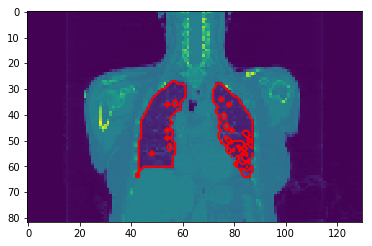

In [53]:
contours = measure.find_contours(both_segment[:,row,:], 0.9)
fig_3, ax = plt.subplots()
ax.imshow(volume_resampled[:,row,:], interpolation='nearest')
    
for n, contour in enumerate(contours):
    #ax.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
    ax.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
    

In [ ]:
dice =[]
jac = []
tpr = []
vs = []
mi = []
for i in metrics:
    dice.append(i[1][0])
    jac.append(i[1][1])
    tpr.append(i[1][2])
    vs.append(i[1][3])
